# Project name: PY sales optimizer

# Step 3 - Experimentation 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
import statsmodels.api
import statsmodels.formula.api as smf
from scipy import stats
from scipy.spatial.distance import cdist
#from yellowbrick.cluster import SilhouetteVisualizer


from sklearn.pipeline import make_pipeline

seed = 100

df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Pakistan Largest Ecommerce Dataset.csv");

## 1. Preprocessing (based on Step1 & Step2)



In [ ]:
#Create Lifetime
df['Working Date2'] = pd.to_datetime(df['Working Date'])
base = df['Working Date2'].max()
df['Date'] = df['Working Date2'].apply(lambda x: x.date())
df['Customer_Since_Date'] = df.groupby('Customer ID')['Date'].transform(min)
df['Lifetime'] = (base.date() - df['Customer_Since_Date']).astype('timedelta64[D]') + 1

#Drop na
df.dropna(axis=0,how='all',inplace=True)
df.dropna(axis=1,how='all',inplace=True)
df.dropna(axis=0,how='any',inplace=True, subset=['Customer ID'])

# Further feature engeneering
df["BI Status"]=df["BI Status"].replace(to_replace=['#REF!'],value=["Net"])
df['BIstatus_num'] = df['BI Status']
df['BIstatus_num'] = df['BIstatus_num'].replace(['Net'], 1)
df['BIstatus_num'] = df['BIstatus_num'].replace(['Valid'], 0)
df['BIstatus_num'] = df['BIstatus_num'].replace(['Gross'], -1)

df['status_new'] = df['status']
df['status_new'] = df['status_new'].replace(['order_refunded', 'refund'],'refunded')
df['status_new'] = df['status_new'].replace(['complete', 'closed'],'completed')
df['status_new'] = df['status_new'].replace(['paid','received','cod',"exchange"],'processing')
df['status_new'] = df['status_new'].replace(['holded','pending_paypal','payment_review'],'pending')

df['Customer Since new']=pd.to_datetime(df['Customer Since']).dt.strftime('%Y%m').astype('int')

#Further cleaning
df=df[df["price"]>0]
df=df[df["grand_total"]>0]

# Further feature engeneering
df['discount_rate'] = (df['discount_amount']/(df['grand_total'] + df['discount_amount']) * 100).round(2)

df['grand_item']=df['price']*df["qty_ordered"]*(1-df['discount_rate']/100)

df=df[df["category_name_1"]!='\\N']

df=df.drop(["sales_commission_code"],axis=1)

# Further feature engeneering
df['payment_method'].replace(['Easypay_MA','easypay_voucher'],'Easypay',inplace=True)
df['payment_method'].replace(['jazzwallet','jazzvoucher'],'Jazz',inplace=True)
df['payment_method'].replace(['customercredit','ublcreditcard'],'Credit',inplace=True)
df['payment_method'].replace(['internetbanking'],'bankalfalah',inplace=True)

df=df.dropna(axis=0,how="any")


## 2. RFM scores (according to Step2)

In [ ]:
#Only focus on positive/"promissing" transactions 
df=df[(df["status_new"]=="completed")|(df["status_new"]=="processing")]

print("Z score = (x-mean)/standard deviation = 3, gives 99.7% of the data points lie between +/- standard deviation. We use this statistics concept to remove outliers!")

#Number of orders (for Frequency)
T1=df.groupby(["Customer ID"]).agg({"increment_id":"count"})
m1=T1["increment_id"].mean()
s1=T1["increment_id"].std()
A1=T1[T1["increment_id"]<=m1+3*s1]
a1=A1.index
lis=[]
for id in df["Customer ID"]:
  lis.append(id in a1)

df1=df.iloc[lis]


# price, qty_ordered, discount_rate (for Monetary)
zpmax=df["price"].mean()+3*df["price"].std()
zpmin=df["price"].mean()-3*df["price"].std()
data=df1[(df1["price"]>=zpmin) & (df1["price"]<=zpmax)]

zqmax=data["qty_ordered"].mean()+3*data["qty_ordered"].std()
zqmin=data["qty_ordered"].mean()-3*data["qty_ordered"].std()
data=data[(data["qty_ordered"]>=zqmin) & (data["qty_ordered"]<=zqmax)]

zdmax=data["discount_rate"].mean()+3*data["discount_rate"].std()
zdmin=data["discount_rate"].mean()-3*data["discount_rate"].std()
data=data[(data["discount_rate"]>=zdmin) & (data["discount_rate"]<=zdmax)]

data

Z score = (x-mean)/standard deviation = 3, gives 99.7% of the data points lie between +/- standard deviation. We use this statistics concept to remove outliers!


,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category_name_1,discount_amount,...,Customer ID,Working Date2,Date,Customer_Since_Date,Lifetime,BIstatus_num,status_new,Customer Since new,discount_rate,grand_item
0,211131.0,complete,7/1/2016,kreations_YI 06-L,1950.0,1.0,1950.0,100147443,Women's Fashion,0.0,...,1.0,2016-07-01,2016-07-01,2016-07-01,789.0,1,completed,201607,0.0,1950.0
7,211139.0,complete,7/1/2016,UK_Namkino Mix Nimco 400 Gms,170.0,1.0,170.0,100147450,Soghaat,0.0,...,6.0,2016-07-01,2016-07-01,2016-07-01,789.0,1,completed,201607,0.0,170.0
10,211142.0,complete,7/1/2016,"GFC_Pedestal Myga Cross Base (Special Guard) 24""",5500.0,1.0,5500.0,100147453,Appliances,0.0,...,9.0,2016-07-01,2016-07-01,2016-07-01,789.0,1,completed,201607,0.0,5500.0
11,211143.0,received,7/1/2016,BK1070200PL,210.0,1.0,366.0,100147454,Soghaat,0.0,...,10.0,2016-07-01,2016-07-01,2016-07-01,789.0,0,processing,201607,0.0,210.0
12,211144.0,received,7/1/2016,BK1130200CF,156.0,1.0,366.0,100147454,Soghaat,0.0,...,10.0,2016-07-01,2016-07-01,2016-07-01,789.0,0,processing,201607,0.0,156.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584508,905190.0,processing,8/28/2018,MEFCUR5B716B0A6B670,499.0,1.0,649.0,100562375,Men's Fashion,0.0,...,1195.0,2018-08-28,2018-08-28,2016-07-15,775.0,-1,processing,201607,0.0,499.0
584509,905191.0,cod,8/28/2018,MEFCOT5A8D1E973B886,399.0,1.0,549.0,100562376,Men's Fashion,0.0,...,115324.0,2018-08-28,2018-08-28,2018-08-28,1.0,0,processing,201808,0.0,399.0
584517,905200.0,cod,8/28/2018,WOFVAL59D5EA84167F9-M,400.0,1.0,550.0,100562383,Women's Fashion,0.0,...,115325.0,2018-08-28,2018-08-28,2018-08-28,1.0,0,processing,201808,0.0,400.0
584518,905202.0,cod,8/28/2018,WOFNIG5B4D7EB0E9FDD-L,499.0,1.0,649.0,100562384,Women's Fashion,0.0,...,115325.0,2018-08-28,2018-08-28,2018-08-28,1.0,0,processing,201808,0.0,499.0


In [ ]:
# Calculate RFM-scores:

# Recency: Days since last purchase

data['Working Date'] = pd.to_datetime(data['Working Date'])
base = data['Working Date'].max()
data['Date'] = data['Working Date'].apply(lambda x: x.date())
data['Most_Recent_Purchase'] = data.groupby('Customer ID')['Date'].transform(max)
data['Recency'] = (base.date() - data['Most_Recent_Purchase']).astype('timedelta64[D]')

# Frequency: Total number of purchases
data['Frequency'] = data.groupby('Customer ID')['increment_id'].transform('nunique')

# Monetary: Total amount spend
data['Monetary'] = data.groupby('Customer ID')['grand_item'].transform('sum')

data


,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category_name_1,discount_amount,...,Lifetime,BIstatus_num,status_new,Customer Since new,discount_rate,grand_item,Most_Recent_Purchase,Recency,Frequency,Monetary
0,211131.0,complete,7/1/2016,kreations_YI 06-L,1950.0,1.0,1950.0,100147443,Women's Fashion,0.0,...,789.0,1,completed,201607,0.0,1950.0,2016-07-01,788.0,1,1950.0
7,211139.0,complete,7/1/2016,UK_Namkino Mix Nimco 400 Gms,170.0,1.0,170.0,100147450,Soghaat,0.0,...,789.0,1,completed,201607,0.0,170.0,2016-07-01,788.0,1,170.0
10,211142.0,complete,7/1/2016,"GFC_Pedestal Myga Cross Base (Special Guard) 24""",5500.0,1.0,5500.0,100147453,Appliances,0.0,...,789.0,1,completed,201607,0.0,5500.0,2016-07-01,788.0,1,5500.0
11,211143.0,received,7/1/2016,BK1070200PL,210.0,1.0,366.0,100147454,Soghaat,0.0,...,789.0,0,processing,201607,0.0,210.0,2016-07-01,788.0,1,366.0
12,211144.0,received,7/1/2016,BK1130200CF,156.0,1.0,366.0,100147454,Soghaat,0.0,...,789.0,0,processing,201607,0.0,156.0,2016-07-01,788.0,1,366.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584508,905190.0,processing,8/28/2018,MEFCUR5B716B0A6B670,499.0,1.0,649.0,100562375,Men's Fashion,0.0,...,775.0,-1,processing,201607,0.0,499.0,2018-08-28,0.0,11,17042.0
584509,905191.0,cod,8/28/2018,MEFCOT5A8D1E973B886,399.0,1.0,549.0,100562376,Men's Fashion,0.0,...,1.0,0,processing,201808,0.0,399.0,2018-08-28,0.0,1,399.0
584517,905200.0,cod,8/28/2018,WOFVAL59D5EA84167F9-M,400.0,1.0,550.0,100562383,Women's Fashion,0.0,...,1.0,0,processing,201808,0.0,400.0,2018-08-28,0.0,2,899.0
584518,905202.0,cod,8/28/2018,WOFNIG5B4D7EB0E9FDD-L,499.0,1.0,649.0,100562384,Women's Fashion,0.0,...,1.0,0,processing,201808,0.0,499.0,2018-08-28,0.0,2,899.0


## 3. RFM - Tabels

In [ ]:
# Standard Frequency (Absolut)
RFM_abs= data[['Customer ID', 'Recency', 'Frequency', 'Monetary']].drop_duplicates()

# Standard Frequency (Scores)
RFM_score=RFM_abs.copy()
RFM_score["Recency"]=pd.qcut(RFM_score["Recency"],5,labels=[5,4,3,2,1])
RFM_score["Frequency"]=pd.cut(RFM_score["Frequency"],bins=[0,1,3,5,10,60],labels=[1,2,3,4,5])
RFM_score["Monetary"]=pd.qcut(RFM_score["Monetary"],5,labels=[1,2,3,4,5])

# Relative Frequency (Absolut)
data['Frequency_rel'] = data['Frequency'] / (data['Lifetime']) * 100
RFM_rel= data[['Customer ID', 'Recency', 'Frequency_rel', 'Monetary']].drop_duplicates()
RFM_rel.index = RFM_rel['Customer ID']
RFM_rel = RFM_rel.drop('Customer ID', axis=1)
Frequency_rel_mean = RFM_rel['Frequency_rel'].mean()
Frequency_rel_std = RFM_rel['Frequency_rel'].std()
RFM_rel = RFM_rel[RFM_rel["Frequency_rel"]<=Frequency_rel_mean+3*Frequency_rel_std]

# Relative Frequency (Scores)
RFM_rel_score=RFM_rel.copy()
RFM_rel_score["Recency"]=pd.qcut(RFM_rel_score["Recency"],5,labels=[5,4,3,2,1])
RFM_rel_score["Frequency_rel"]=pd.qcut(RFM_rel_score["Frequency_rel"],5,labels=[1,2,3,4,5])
RFM_rel_score["Monetary"]=pd.qcut(RFM_rel_score["Monetary"],5,labels=[1,2,3,4,5])
RFM_rel_score["RFM_Rel_Score"] = RFM_rel_score["Recency"].astype(str) + RFM_rel_score["Frequency_rel"].astype(str) + RFM_rel_score["Monetary"].astype(str)


In [ ]:
# RFM_abs
# RFM_score
# RFM_rel
# RFM_rel_score



,Recency,Frequency_rel,Monetary,RFM_Rel_Score
Customer ID,,,,
1.0,1,1,3,113
6.0,1,1,1,111
9.0,1,1,4,114
10.0,1,1,1,111
11.0,2,4,2,242
...,...,...,...,...
28829.0,5,1,1,511
111546.0,5,5,2,552
111664.0,5,5,3,553


## 4. Summary baseline Models (details see Step 2) 

### 4.1. Model 1: K-Means on RFM values

In [ ]:
# Scale the data between 0 and 1
RFM=RFM_abs.copy().drop(["Customer ID"],axis=1)
scaler=preprocessing.MinMaxScaler().fit(RFM)
RFM=scaler.transform(RFM)
#best k choosen by ellbow-method and silhouette analysis (see step 2)
kmeans=KMeans(n_clusters=4, random_state = seed)
kmeans.fit(RFM)
# add now the predicted cluster to the RFM table
RFM_res = RFM_abs.copy()
RFM_res['Cluster1'] = kmeans.labels_

silhouette_score1 = silhouette_score(RFM,kmeans.labels_,metric="sqeuclidean")
Inertia1 = kmeans.inertia_

print(silhouette_score1)
print(Inertia1)

0.6743543307993832
537.999700223728


### 4.2. Model 2: K-Means on RFM scores

In [ ]:
# Scale the data between 0 and 1
RFM=RFM_score.copy().drop(["Customer ID"],axis=1)
scaler=preprocessing.MinMaxScaler().fit(RFM)
RFM=scaler.transform(RFM)
#best k choosen by ellbow-method and silhouette analysis (see step 2)
kmeans=KMeans(n_clusters=4, random_state=seed)
kmeans.fit(RFM)
# add now the predicted cluster to the RFM table
RFM_res = RFM_res.copy()
RFM_res['Cluster2'] = kmeans.labels_

silhouette_score2 = silhouette_score(RFM,kmeans.labels_,metric="sqeuclidean")
Inertia2 = kmeans.inertia_

print(silhouette_score2)
print(Inertia2)

0.5258373262429944
7339.128158886517


### 4.3. Model 3: K-Means on RFM relative frequency - no standardise data

In [ ]:
# Fit best number of clusters (see step 2)
kmeans = KMeans(n_clusters = 4, random_state = seed)
pipeline = make_pipeline(kmeans)
pipeline.fit(RFM_rel)

predicts = pipeline.predict(RFM_rel)
RFM_rel_group = RFM_rel_score['RFM_Rel_Score']
outcome = pd.DataFrame({'predicts': predicts, 'RFM_rel_group': RFM_rel_group})
RFM_rel_pred3 = pd.crosstab(outcome['RFM_rel_group'], outcome['predicts'])
RFM_rel_pred3.columns = ['M3_0', 'M3_1', 'M3_2', 'M3_3']

# add now the predicted cluster to the RFM table
RFM_rel_res = RFM_rel.copy()
RFM_rel_res['Cluster3'] = kmeans.labels_


silhouette_score3 = silhouette_score(RFM_rel,kmeans.labels_,metric="sqeuclidean")
Inertia3 = kmeans.inertia_

print(silhouette_score3)
print(Inertia3)

0.9050030051089372
7192973735961.457


### 4.4. Model 4: K-Means on RFM relative frequency - standardise data

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = preprocessing.StandardScaler()

# Fit best number of clusters (see step 2)
kmeans = KMeans(n_clusters = 4, random_state = seed)
pipeline = make_pipeline(scaler, kmeans)
pipeline.fit(RFM_rel)
predicts = pipeline.predict(RFM_rel)
RFM_rel_group = RFM_rel_score['RFM_Rel_Score']
outcome = pd.DataFrame({'predicts': predicts, 'RFM_rel_group': RFM_rel_group})
RFM_rel_pred4 = pd.crosstab(outcome['RFM_rel_group'], outcome['predicts'])
RFM_rel_pred4.columns = ['M4_0', 'M4_1', 'M4_2', 'M4_3']

RFM_rel_pred = pd.merge(RFM_rel_pred3, RFM_rel_pred4, on='RFM_rel_group')

# add now the predicted cluster to the RFM table
RFM_rel_res = RFM_rel_res.copy()
RFM_rel_res['Cluster4'] = kmeans.labels_

silhouette_score4 = silhouette_score(RFM_rel,kmeans.labels_,metric="sqeuclidean")
Inertia4 = kmeans.inertia_

print(silhouette_score4)
print(Inertia4)

-0.006573881863770184
68606.4553391219


### 4.5. Model 5: K-Means on RFM relative frequency - standardised - remove best group 555


In [ ]:
RFM_rel_excl555 = RFM_rel[RFM_rel_score['RFM_Rel_Score'] != '555']

# Fit best number of clusters (see step 2)
kmeans = KMeans(n_clusters = 4, random_state = seed)
pipeline = make_pipeline(scaler, kmeans)
pipeline.fit(RFM_rel_excl555)
predicts = pipeline.predict(RFM_rel_excl555)
RFM_rel_group = RFM_rel_score['RFM_Rel_Score'][RFM_rel_score['RFM_Rel_Score'] != '555']
outcome = pd.DataFrame({'predicts': predicts, 'RFM_rel_group': RFM_rel_group})

RFM_rel_pred5 = pd.crosstab(outcome['RFM_rel_group'], outcome['predicts'])
RFM_rel_pred5.columns = ['M5_0', 'M5_1', 'M5_2', 'M5_3']
RFM_rel_pred = pd.merge(RFM_rel_pred, RFM_rel_pred5, on='RFM_rel_group')
# add now the predicted cluster to the RFM table
RFM_rel_res5 = RFM_rel_excl555.copy()
RFM_rel_res5['Cluster5'] = kmeans.labels_

silhouette_score5 = silhouette_score(RFM_rel_excl555,kmeans.labels_,metric="sqeuclidean")
Inertia5 = kmeans.inertia_

print(silhouette_score5)
print(Inertia5)

0.011792098235487833
75330.01767072134


## 5. Model interpretation and visualisation (see step2)

## 6. Experimentation

## Part 1

Based on the 5 models / clusters generated above, we can see:
- Cluster 1 is heavily influenced by recency score
- Cluster 3 is heavily influenced by monetary score
- Cluster 4 is heavily influenced by monetary score but also taken into account freqency and recency scores
- Other clusters are mixed

Hence **Cluster 4** (or **model 4**) has the best balance, especially the **group 2** is the best targeting segment given the highest monetary amount, highest shopping frequency and good recency socre (i.e. shopped recently)

In [ ]:
data_res = data.merge(right=RFM_rel_res['Cluster4'].reset_index(),on='Customer ID',how='left')
data_res_g2 = data_res[data_res.Cluster4==2]
data_res.head()

,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category_name_1,discount_amount,...,status_new,Customer Since new,discount_rate,grand_item,Most_Recent_Purchase,Recency,Frequency,Monetary,Frequency_rel,Cluster4
0,211131.0,complete,7/1/2016,kreations_YI 06-L,1950.0,1.0,1950.0,100147443,Women's Fashion,0.0,...,completed,201607,0.0,1950.0,2016-07-01,788.0,1,1950.0,0.126743,0.0
1,211139.0,complete,7/1/2016,UK_Namkino Mix Nimco 400 Gms,170.0,1.0,170.0,100147450,Soghaat,0.0,...,completed,201607,0.0,170.0,2016-07-01,788.0,1,170.0,0.126743,0.0
2,211142.0,complete,7/1/2016,"GFC_Pedestal Myga Cross Base (Special Guard) 24""",5500.0,1.0,5500.0,100147453,Appliances,0.0,...,completed,201607,0.0,5500.0,2016-07-01,788.0,1,5500.0,0.126743,0.0
3,211143.0,received,7/1/2016,BK1070200PL,210.0,1.0,366.0,100147454,Soghaat,0.0,...,processing,201607,0.0,210.0,2016-07-01,788.0,1,366.0,0.126743,0.0
4,211144.0,received,7/1/2016,BK1130200CF,156.0,1.0,366.0,100147454,Soghaat,0.0,...,processing,201607,0.0,156.0,2016-07-01,788.0,1,366.0,0.126743,0.0


In [ ]:
# average transaction revenue
data_res['YearMonth'] = (data_res.Year*100 + data_res.Month).astype(int).astype(str)
data_res_g2['YearMonth'] = (data_res_g2.Year*100 + data_res_g2.Month).astype(int).astype(str)

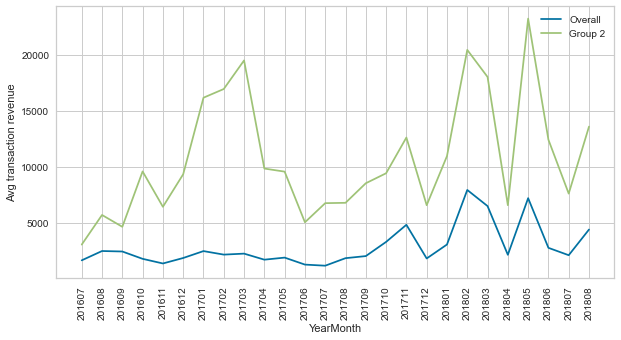

the overall average transaction revenue is 2889
the group 2 average transaction revenue is 10750
the average transaction revenue from group 2 is 310 % higher than the overall


In [ ]:
t1=data_res.groupby('YearMonth')['grand_item'].mean()
t2=data_res_g2.groupby('YearMonth')['grand_item'].mean()

plt.figure(figsize=(10,5))
sns.lineplot(data=t1,label='Overall')
sns.lineplot(data=t2,label='Group 2')
plt.ylabel('Avg transaction revenue')
plt.xticks(rotation=90)
plt.legend()
plt.show()

print("the overall average transaction revenue is",int(t1.mean()))
print("the group 2 average transaction revenue is",int(t2.mean()))
print("the average transaction revenue from group 2 is",int((t2/t1-1).mean()*100),"% higher than the overall")

If we target 'group 2' customer, with every one additional 'group 2' type customer, we are expecting to generate extra 7,861 revenue or 1,179 profit (with 15% profit margin) for each transaction.

Hence additional marketomg cost or discount incentive would be worthwhile as long as less than the extra profit it can generate (i.e. 1179 per transaction in this case)

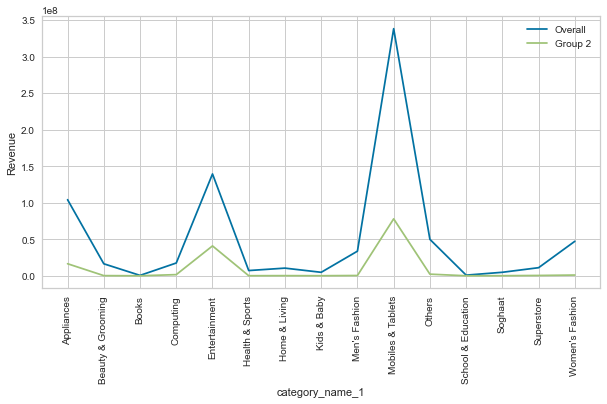

In [ ]:
# Best selling category
t3 = data_res.groupby(['category_name_1'])['grand_item'].sum()
t4 = data_res_g2.groupby(['category_name_1'])['grand_item'].sum()

plt.figure(figsize=(10,5))
sns.lineplot(data=t3,label='Overall')
sns.lineplot(data=t4,label='Group 2')
plt.ylabel('Revenue')
plt.xticks(rotation=90)
plt.legend()
plt.show()

Hence the best selling category for targeting is 'Mobiles & Tablets', 'Entertainment' and 'Appliances', especially for group 2

These categories should be targeted in marketing

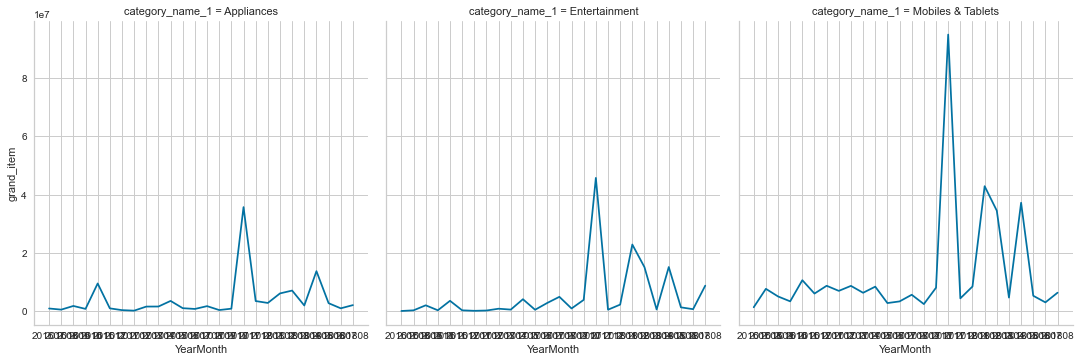

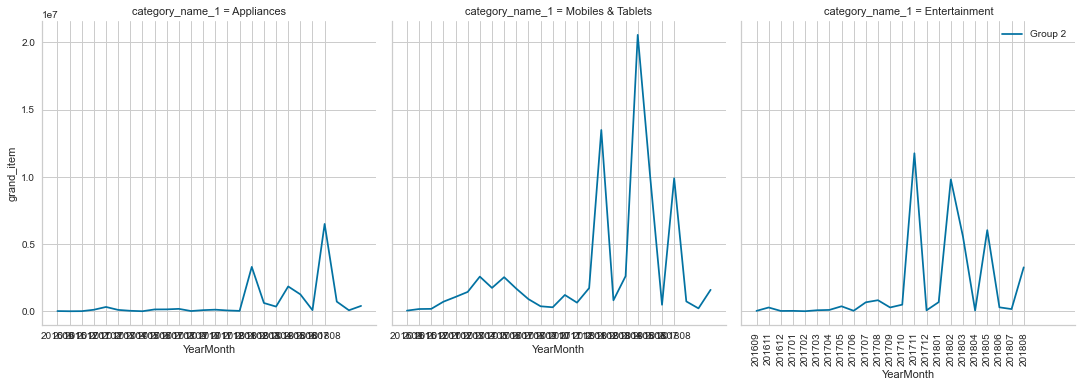

In [ ]:
# Best selling category by month
Best_category = (data_res.category_name_1=='Mobiles & Tablets') | (data_res.category_name_1=='Entertainment')|(data_res.category_name_1=='Appliances')
t5 = data_res[Best_category].groupby(['YearMonth','category_name_1'])['grand_item'].sum().reset_index()
t6 = data_res_g2[Best_category].groupby(['YearMonth','category_name_1'])['grand_item'].sum().reset_index()

sns.relplot(x='YearMonth',y='grand_item',data=t5,col='category_name_1',kind='line',label='Overall',col_wrap=3,height=5)
sns.relplot(x='YearMonth',y='grand_item',data=t6,col='category_name_1',kind='line',label='Group 2',col_wrap=3,height=5)
plt.ylabel('Revenue')
plt.xticks(rotation=90)
plt.legend()
plt.show()

# need to fix the xlabel, legend & sort category

No obvious seasonality by category

## Part 2

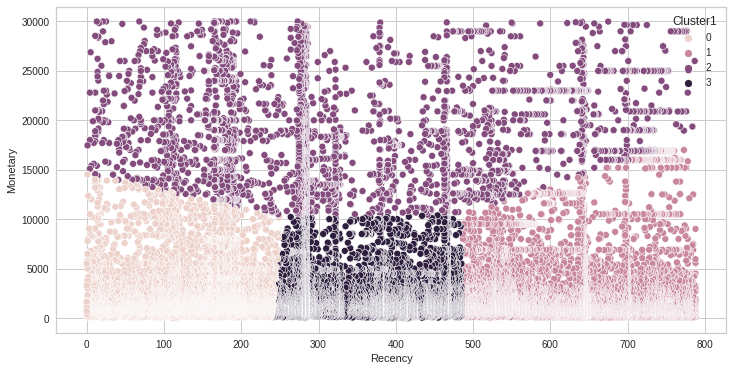

In [ ]:
# 2 out of 3 customers with just one order
# Split in 1-time customers and recurring customers
# First focus on 1-time customers
# Exclude "extrem" moentary values (>30000). This considers 324 customers
RFM_abs1=RFM_abs[(RFM_abs["Frequency"]==1)& (RFM_abs["Monetary"]<=30000)]

RFM=RFM_abs1.copy().drop(["Customer ID"],axis=1)
scaler=preprocessing.MinMaxScaler().fit(RFM)
RFM=scaler.transform(RFM)

kmeans=KMeans(n_clusters=4, random_state = seed)
kmeans.fit(RFM)
# add now the predicted cluster to the RFM table
RFM_res = RFM_abs1.copy()
RFM_res['Cluster1'] = kmeans.labels_

plt.figure(figsize=(12,6))
sns.scatterplot(RFM_res["Recency"],RFM_res["Monetary"], hue=RFM_res["Cluster1"]);

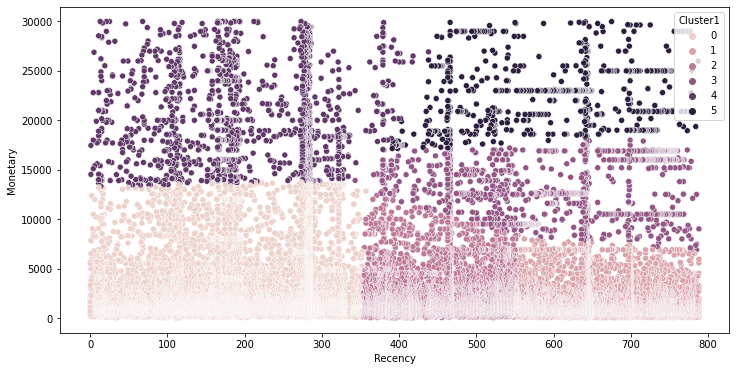

In [ ]:
RFM_abs1=RFM_abs[(RFM_abs["Frequency"]==1)& (RFM_abs["Monetary"]<=30000)]
RFM=RFM_abs1.copy().drop(["Customer ID","Frequency"],axis=1)
scaler=preprocessing.MinMaxScaler().fit(RFM)
RFM=scaler.transform(RFM)

from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth=estimate_bandwidth(RFM, quantile=0.18)
cluster=MeanShift(bandwidth=bandwidth)
cluster.fit(RFM)

RFM_res = RFM_abs1.copy()
RFM_res['Cluster1'] =cluster.labels_
plt.figure(figsize=(12,6))
sns.scatterplot(RFM_res["Recency"],RFM_res["Monetary"], hue=RFM_res["Cluster1"]);

In [ ]:
RFM_res

# RFM_res.to_csv('/content/drive/MyDrive/Colab Notebooks/RFM_Result_OneTimeCustomers.csv', index=False)

rfm_otc = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RFM_Result_OneTimeCustomers.csv')
rfm_otc

,Customer ID,Recency,Frequency,Monetary,Cluster1
0,1.0,788.0,1,1950.00,1
1,6.0,788.0,1,170.00,1
2,9.0,788.0,1,5500.00,1
3,10.0,788.0,1,366.00,1
4,26.0,788.0,1,4500.00,1
...,...,...,...,...,...
49569,115318.0,0.0,1,1638.75,0
49570,110259.0,0.0,1,798.00,0
49571,115322.0,0.0,1,1048.00,0
49572,115324.0,0.0,1,399.00,0


In [ ]:
#Recurring customers
RFM_abs1=RFM_abs[(RFM_abs["Frequency"]!=1)]

In [ ]:
import plotly.express as px
fig = px.scatter_3d(RFM_abs1, x="Frequency", y="Monetary", z="Recency")

fig.update_traces(marker=dict(size=2,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

In [ ]:
RFM_abs1=RFM_abs[(RFM_abs["Frequency"]!=1)&(RFM_abs["Monetary"]<=250000)&(RFM_abs["Frequency"]<=20)]


In [ ]:
RFM=RFM_abs1.copy().drop(["Customer ID"],axis=1)
scaler=preprocessing.MinMaxScaler().fit(RFM)
RFM=scaler.transform(RFM)

kmeans=KMeans(n_clusters=5, random_state = seed)
kmeans.fit(RFM)
# add now the predicted cluster to the RFM table
RFM_res = RFM_abs1.copy()
RFM_res['Cluster1'] = kmeans.labels_


In [ ]:
#result recurring customers
RFM_res
# RFM_res.to_csv('/content/drive/MyDrive/Colab Notebooks/RFM_Result_RecurringCustomers.csv', index=False)
rfm_rec_c = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RFM_Result_RecurringCustomers.csv')
rfm_rec_c


,Customer ID,Recency,Frequency,Monetary,Cluster1
0,11.0,560.0,4,945.0000,1
1,15.0,231.0,13,19834.1760,2
2,19.0,644.0,10,5526.0000,1
3,23.0,54.0,14,29576.4000,2
4,22.0,788.0,3,1277.1896,1
...,...,...,...,...,...
25445,114931.0,5.0,2,1449.0000,3
25446,115125.0,4.0,3,2710.0000,3
25447,115123.0,2.0,4,67476.0000,3
25448,115030.0,3.0,3,11484.0000,3


In [ ]:
import plotly.express as px

RFMp=RFM_res.drop(["Cluster1"],axis=1)
fig = px.scatter_3d(RFMp, x="Frequency", y="Monetary", z="Recency",labels=RFM_res["Cluster1"], color=RFM_res["Cluster1"])

fig = fig.update_traces(marker=dict(size=2,
                              line=dict(width=2,
                                        color=RFM_res["Cluster1"])),
                  selector=dict(mode='markers'))

fig.layout.showlegend = True
fig.show()

## Part 3

In [ ]:
#Deep dive into the clusters of part 2, to get an idea which products we could push with marketing
#most interesstings groups are group 0 and 4. both have a short recency. additionaly look deeper into group 5 (heigher recnecy but also a high monetary score)

rfm_otc = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RFM_Result_OneTimeCustomers.csv')
RFM_res_merged_TS = data.merge(right=rfm_otc[['Customer ID','Cluster1']].reset_index(),on='Customer ID',how='left')
RFM_res_merged_TS


,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category_name_1,discount_amount,...,Customer Since new,discount_rate,grand_item,Most_Recent_Purchase,Recency,Frequency,Monetary,Frequency_rel,index,Cluster1
0,211131.0,complete,7/1/2016,kreations_YI 06-L,1950.0,1.0,1950.0,100147443,Women's Fashion,0.0,...,201607,0.0,1950.0,2016-07-01,788.0,1,1950.0,0.126743,0.0,1.0
1,211139.0,complete,7/1/2016,UK_Namkino Mix Nimco 400 Gms,170.0,1.0,170.0,100147450,Soghaat,0.0,...,201607,0.0,170.0,2016-07-01,788.0,1,170.0,0.126743,1.0,1.0
2,211142.0,complete,7/1/2016,"GFC_Pedestal Myga Cross Base (Special Guard) 24""",5500.0,1.0,5500.0,100147453,Appliances,0.0,...,201607,0.0,5500.0,2016-07-01,788.0,1,5500.0,0.126743,2.0,1.0
3,211143.0,received,7/1/2016,BK1070200PL,210.0,1.0,366.0,100147454,Soghaat,0.0,...,201607,0.0,210.0,2016-07-01,788.0,1,366.0,0.126743,3.0,1.0
4,211144.0,received,7/1/2016,BK1130200CF,156.0,1.0,366.0,100147454,Soghaat,0.0,...,201607,0.0,156.0,2016-07-01,788.0,1,366.0,0.126743,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239015,905190.0,processing,8/28/2018,MEFCUR5B716B0A6B670,499.0,1.0,649.0,100562375,Men's Fashion,0.0,...,201607,0.0,499.0,2018-08-28,0.0,11,17042.0,1.419355,NaN,NaN
239016,905191.0,cod,8/28/2018,MEFCOT5A8D1E973B886,399.0,1.0,549.0,100562376,Men's Fashion,0.0,...,201808,0.0,399.0,2018-08-28,0.0,1,399.0,100.000000,49572.0,0.0
239017,905200.0,cod,8/28/2018,WOFVAL59D5EA84167F9-M,400.0,1.0,550.0,100562383,Women's Fashion,0.0,...,201808,0.0,400.0,2018-08-28,0.0,2,899.0,200.000000,NaN,NaN
239018,905202.0,cod,8/28/2018,WOFNIG5B4D7EB0E9FDD-L,499.0,1.0,649.0,100562384,Women's Fashion,0.0,...,201808,0.0,499.0,2018-08-28,0.0,2,899.0,200.000000,NaN,NaN


In [ ]:
#build dataset which contains only data of group 0,4,5 and investigate data in a time series analysis
RFM_res_merged_Cluster_TS = RFM_res_merged_TS[(RFM_res_merged_TS['Cluster1']==0) | (RFM_res_merged_TS['Cluster1']==4) | (RFM_res_merged_TS['Cluster1']==5) ]


In [ ]:
import plotly.express as px

RFM_res_merged_Cluster_TS_count = RFM_res_merged_Cluster_TS.groupby(['created_at', 'Cluster1']).agg('count')
RFM_res_merged_Cluster_TS_count = RFM_res_merged_Cluster_TS_count.reset_index()

RFM_res_merged_Cluster_TS_count['created_at'] = pd.to_datetime(RFM_res_merged_Cluster_TS_count['created_at'])
RFM_res_merged_Cluster_TS_count = RFM_res_merged_Cluster_TS_count.sort_values(by='created_at')

fig = px.line(RFM_res_merged_Cluster_TS_count, x='created_at', y='item_id', color='Cluster1', title='<b>Count transactions per day - separated by observed groups (0,4,5) - One time customer</b>')
fig.update_xaxes(rangeslider_visible=True)

fig.show()

**Observations:**
there are manily two peaks in the timeline to investigate .

*   First between 17.11 - 24.11 - this was the black friday week in Pakistan
*   second import peak was end of march 2018. during this period starting mid till end of march is an historical national day (23.03.) around this period there happens a lot of sales activies in the entire country, so this is an important period to make special offers. 













In [ ]:
# do the same analysis on the recurring customers - they bought more than one times (Group 2,3,4)
rfm_rec_c = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RFM_Result_RecurringCustomers.csv')

RFM_res_merged_3d_TS = data.merge(right=rfm_rec_c[['Customer ID','Cluster1']].reset_index(),on='Customer ID',how='left')

RFM_res_merged_3d_TS.head()

RFM_res_merged_3d_TS = RFM_res_merged_3d_TS[(RFM_res_merged_3d_TS['Cluster1']==2) | (RFM_res_merged_3d_TS['Cluster1']==3) | (RFM_res_merged_3d_TS['Cluster1']==4) ]


RFM_res_merged_3d_TS_count = RFM_res_merged_3d_TS.groupby(['created_at', 'Cluster1']).agg('count')
RFM_res_merged_3d_TS_count = RFM_res_merged_3d_TS_count.reset_index()
RFM_res_merged_3d_TS_count['created_at'] = pd.to_datetime(RFM_res_merged_3d_TS_count['created_at'])
RFM_res_merged_3d_TS_count = RFM_res_merged_3d_TS_count.sort_values(by='created_at')


RFM_res_merged_3d_TS_count.head(5)



,created_at,Cluster1,item_id,status,sku,price,qty_ordered,grand_total,increment_id,category_name_1,...,status_new,Customer Since new,discount_rate,grand_item,Most_Recent_Purchase,Recency,Frequency,Monetary,Frequency_rel,index
1465,2016-07-01,2.0,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14
1466,2016-07-01,3.0,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
1542,2016-07-02,2.0,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
1543,2016-07-02,3.0,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
1625,2016-07-03,2.0,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11


In [ ]:
fig = px.line(RFM_res_merged_3d_TS_count, x='created_at', y='item_id', color='Cluster1', title='<b>Count transactions per day - separated by observed groups (2,3,4) - recurring customer</b>')
fig.update_xaxes(rangeslider_visible=True)

fig.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#transaction per day, of all groups
RFM_res_merged_Cluster_TS_count_2 = RFM_res_merged_Cluster_TS.groupby(['created_at']).agg('count')
RFM_res_merged_Cluster_TS_count_2 = RFM_res_merged_Cluster_TS_count_2.reset_index()
RFM_res_merged_Cluster_TS_count_2['created_at'] = pd.to_datetime(RFM_res_merged_Cluster_TS_count_2['created_at'])
RFM_res_merged_Cluster_TS_count_2 = RFM_res_merged_Cluster_TS_count_2.sort_values(by='created_at')

RFM_res_merged_Cluster_TS_mean_discount_rate = RFM_res_merged_Cluster_TS
# RFM_res_merged_Cluster_TS_mean_discount_rate = RFM_res_merged_Cluster_TS_mean_discount_rate.reset_index()
RFM_res_merged_Cluster_TS_mean_discount_rate =RFM_res_merged_Cluster_TS_mean_discount_rate.groupby(['created_at'])['discount_rate'].mean()
RFM_res_merged_Cluster_TS_mean_discount_rate = RFM_res_merged_Cluster_TS_mean_discount_rate.reset_index()
RFM_res_merged_Cluster_TS_mean_discount_rate['created_at'] = pd.to_datetime(RFM_res_merged_Cluster_TS_mean_discount_rate['created_at'])
RFM_res_merged_Cluster_TS_mean_discount_rate = RFM_res_merged_Cluster_TS_mean_discount_rate.sort_values(by='created_at')


# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])


# Add traces
fig.add_trace(
    go.Scatter(x=RFM_res_merged_Cluster_TS_count_2['created_at'], y=RFM_res_merged_Cluster_TS_count_2['item_id'], name="Overall transactions per day"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=RFM_res_merged_Cluster_TS_mean_discount_rate['created_at'],y=RFM_res_merged_Cluster_TS_mean_discount_rate['discount_rate'], name="Mean Discount rate per day"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="<b>Overall transactions (Groups 0,4,5) vs Average Discount Rate - One Time Customer</b>"
)

# Set x-axis title
fig.update_xaxes(title_text="xaxis title")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Transactions</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Mean discount rate</b>", secondary_y=True)

fig.update_xaxes(rangeslider_visible=True)

fig.show()


**Observation**: 
We can see there are a lot of discount activities on the timeline, but most of them did not drive the sales activities. So we should think about how we want to deal with those discount rates in future.

In [59]:
# start hier with analysis of recurring customers

RFM_res_merged_3d_TS = RFM_res_merged_3d_TS[(RFM_res_merged_3d_TS['Cluster1']==2) | (RFM_res_merged_3d_TS['Cluster1']==3) | (RFM_res_merged_3d_TS['Cluster1']==4) ]

RFM_res_merged_3d_TS_count_2 = RFM_res_merged_3d_TS.groupby('created_at').count()
RFM_res_merged_3d_TS_count_2 = RFM_res_merged_3d_TS_count_2.reset_index()

RFM_res_merged_3d_TS_count_2['created_at'] = pd.to_datetime(RFM_res_merged_3d_TS_count_2['created_at'])
RFM_res_merged_3d_TS_count_2 = RFM_res_merged_3d_TS_count_2.sort_values(by='created_at')




RFM_res_merged_3d_TS_mean_discount_rate = RFM_res_merged_3d_TS
RFM_res_merged_3d_TS_mean_discount_rate = RFM_res_merged_3d_TS_mean_discount_rate.reset_index()
RFM_res_merged_3d_TS_mean_discount_rate =RFM_res_merged_3d_TS_mean_discount_rate.groupby(['created_at'])['discount_rate'].mean()

RFM_res_merged_3d_TS_mean_discount_rate = RFM_res_merged_3d_TS_mean_discount_rate.reset_index()

RFM_res_merged_3d_TS_mean_discount_rate['created_at'] = pd.to_datetime(RFM_res_merged_3d_TS_mean_discount_rate['created_at'])
RFM_res_merged_3d_TS_mean_discount_rate = RFM_res_merged_3d_TS_mean_discount_rate.sort_values(by='created_at')

#RFM_res_merged_3d_TS_mean_discount_rate[RFM_res_merged_3d_TS_mean_discount_rate['created_at']=='2018-03-18']

#RFM_res_merged_3d_TS_count_2

# # Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])


# Add traces
fig.add_trace(
    go.Scatter(x=RFM_res_merged_3d_TS_count_2['created_at'], y=RFM_res_merged_3d_TS_count_2['item_id'], name="Overall transactions per day"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=RFM_res_merged_3d_TS_mean_discount_rate['created_at'],y=RFM_res_merged_3d_TS_mean_discount_rate['discount_rate'], name="Mean Discount rate per day"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="<b>Overall transactions (Groups 2,3,4) vs Average Discount Rate (Recurring Customers)</b>"
)

# Set x-axis title
fig.update_xaxes(title_text="xaxis title")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Transactions</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Mean discount rate</b>", secondary_y=True)

fig.update_xaxes(rangeslider_visible=True)

fig.show()




**Observation**: <br>
Compared to previous analysis of one time customer, we can see here that in many cases when we offer higher discount rates, the customer bought more on those days.<br> 
Trends can also be seen here: e.g. Black Friday week in 2016 (Nov), 2017 (Nov) or again the end of March sales on the national day.

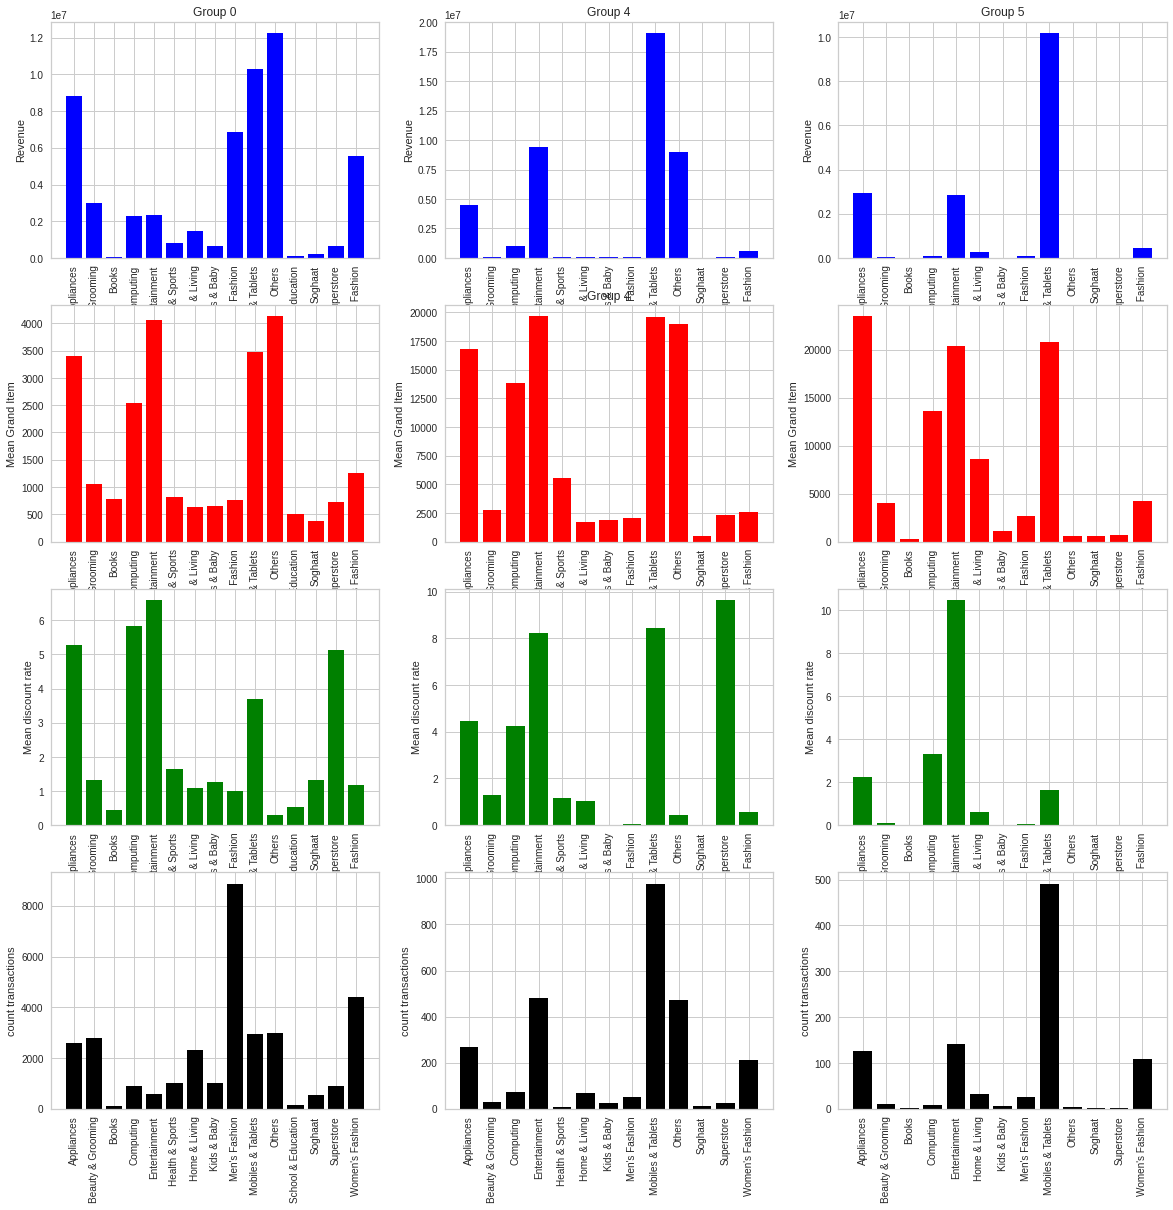

In [ ]:
result_sum_by_cat_0 = RFM_res_merged_Cluster0.groupby(['category_name_1'])['grand_item'].sum()
result_mean_by_cat_0 = RFM_res_merged_Cluster0.groupby(['category_name_1'])['grand_item'].mean()
result_dr_mean_by_cat_0 = RFM_res_merged_Cluster0.groupby(['category_name_1'])['discount_rate'].mean()
result_count_by_cat_0 = RFM_res_merged_Cluster0.groupby(['category_name_1']).count()

result_sum_by_cat_4 = RFM_res_merged_Cluster4.groupby(['category_name_1'])['grand_item'].sum()
result_mean_by_cat_4 = RFM_res_merged_Cluster4.groupby(['category_name_1'])['grand_item'].mean()
result_dr_mean_by_cat_4 = RFM_res_merged_Cluster4.groupby(['category_name_1'])['discount_rate'].mean()
result_count_by_cat_4 = RFM_res_merged_Cluster4.groupby(['category_name_1']).count()

result_sum_by_cat_5 = RFM_res_merged_Cluster5.groupby(['category_name_1'])['grand_item'].sum()
result_mean_by_cat_5 = RFM_res_merged_Cluster5.groupby(['category_name_1'])['grand_item'].mean()
result_dr_mean_by_cat_5 = RFM_res_merged_Cluster5.groupby(['category_name_1'])['discount_rate'].mean()
result_count_by_cat_5 = RFM_res_merged_Cluster5.groupby(['category_name_1']).count()


g0 = pd.DataFrame(result_sum_by_cat_0)   
g0_mean = pd.DataFrame(result_mean_by_cat_0) 
g0_dr_mean = pd.DataFrame(result_dr_mean_by_cat_0) 
g0_count = pd.DataFrame(result_count_by_cat_0) 

g4 = pd.DataFrame(result_sum_by_cat_4)   
g4_mean = pd.DataFrame(result_mean_by_cat_4)   
g4_dr_mean = pd.DataFrame(result_dr_mean_by_cat_4) 
g4_count = pd.DataFrame(result_count_by_cat_4) 

g5 = pd.DataFrame(result_sum_by_cat_5)   
g5_mean = pd.DataFrame(result_mean_by_cat_5)   
g5_dr_mean = pd.DataFrame(result_dr_mean_by_cat_5) 
g5_count = pd.DataFrame(result_count_by_cat_5) 

#Group0 - short recency, low monetary value ( they bought mostly cheap products like fashion)
plt.figure(figsize=(20,20))
plt.subplot(4,3,1)
plt.bar(g0.index, g0.grand_item, color='blue')
plt.xticks(rotation=90)
plt.ylabel('Revenue')
plt.title('Group 0')

plt.subplot(4,3,4)
plt.bar(g0_mean.index, g0_mean.grand_item, color='red' )
plt.xticks(rotation=90)
plt.ylabel('Mean Grand Item')
# plt.title('Group 0')

plt.subplot(4,3,7)
plt.bar(g0_dr_mean.index, g0_dr_mean.discount_rate, color='green' )
plt.xticks(rotation=90)
plt.ylabel('Mean discount rate')
# plt.title('Mean discount rate per category - Group 0')

plt.subplot(4,3,10)
plt.bar(g0_count.index, g0_count.discount_rate, color='black' )
plt.xticks(rotation=90)
plt.ylabel('count transactions')
# plt.title('count per category - Group 0')


#Group4 short recency, high monetary value ( these customer bought mostly more expensive products like entertainment and tablets / mobiles)
plt.subplot(4,3,2)
plt.bar(g4.index, g4.grand_item, color='blue')
plt.xticks(rotation=90)
plt.ylabel('Revenue')
plt.title('Group 4')


plt.subplot(4,3,5)
plt.bar(g4_mean.index, g4_mean.grand_item, color='red' )
plt.xticks(rotation=90)
plt.ylabel('Mean Grand Item')
plt.title('Group 4')

plt.subplot(4,3,8)
plt.bar(g4_dr_mean.index, g4_dr_mean.discount_rate, color='green' )
plt.xticks(rotation=90)
plt.ylabel('Mean discount rate')
# plt.title('Mean discount rate per category - Group 4')

plt.subplot(4,3,11)
plt.bar(g4_count.index, g4_count.discount_rate, color='black' )
plt.xticks(rotation=90)
plt.ylabel('count transactions')
# plt.title('count per category - Group 4')

#Group5 
plt.subplot(4,3,3)
plt.bar(g5.index, g5.grand_item, color='blue')
plt.xticks(rotation=90)
plt.ylabel('Revenue')
plt.title('Group 5')


plt.subplot(4,3,6)
plt.bar(g5_mean.index, g5_mean.grand_item, color='red' )
plt.xticks(rotation=90)
plt.ylabel('Mean Grand Item')
# plt.title('Mean Grand Item per category - Group 5')

plt.subplot(4,3,9)
plt.bar(g5_dr_mean.index, g5_dr_mean.discount_rate, color='green' )
plt.xticks(rotation=90)
plt.ylabel('Mean discount rate')
# plt.title('Mean discount rate per category - Group 5')

plt.subplot(4,3,12)
plt.bar(g5_count.index, g5_count.discount_rate, color='black' )
plt.xticks(rotation=90)
plt.ylabel('count transactions')
# plt.title('count per category - Group 5')

plt.show()

#Oberservations of one time customer

# in common Groups 0, 4, 5:
# in all of these groups Moiles and Tables have the most revenue

# Group 0: low recency, low monetary value (low value customers)
# revenue: beside of Mobile & Tablets, also Fashion and Appliances have an high revenue
# average price: because of low monetary value, we can observe also the average price is much lower than in the other groups.
# discount rates: higher average price leads to a high discount rate in this category
# customers: this low price segement is mainly diven my fashion customers

# Group 4: low recency, high monetary value (high value customers)
# revenue: Only  Mobile & Tablets and Entertainment products are the most important driver of this group (others as well, but we dont know whats behind of that)
# average price: Mobile & Tablets and Entertainment products have the highest average price
# discount rates: same as in group 0
# customers: driven mainly by Mobile & Tablets & Entertainment customers

# Group 5: higher recency but also high monetary value
# revenue: similar as in group 4, plus Appliances
# average price: similar as in group 4, but Appliances has here the highest average price compared to Enterainment and Mobiles & Tables
# discount rates: only entertainment producs have a significant discount rate
# customers: driven mainly by Mobile & Tablets & Entertainment customers

In [ ]:
#Cluster analysis of 3D chart 

In [ ]:
#create CSV which contains result of cluster 1
#RFM_res.to_csv('/content/drive/MyDrive/Colab Notebooks/Result_Cluster1_3d.csv', index=False)

RFM_res = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Result_Cluster1_3d.csv')

In [ ]:
RFM_res_merged_3d = data.merge(right=RFM_res.reset_index(),on='Customer ID',how='left')
RFM_res_merged_3d.head()

,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category_name_1,discount_amount,payment_method,Working Date,BI Status,MV,Year,Month,Customer Since,M-Y,FY,Customer ID,Working Date2,Date,Customer_Since_Date,Lifetime,BIstatus_num,status_new,Customer Since new,discount_rate,grand_item,Most_Recent_Purchase,Recency_x,Frequency_x,Monetary_x,Frequency_rel,index,Recency_y,Frequency_y,Monetary_y,Cluster1
0,211131.0,complete,7/1/2016,kreations_YI 06-L,1950.0,1.0,1950.0,100147443,Women's Fashion,0.0,cod,2016-07-01,Net,"1,950",2016.0,7.0,2016-7,7-2016,FY17,1.0,2016-07-01,2016-07-01,2016-07-01,789.0,1,completed,201607,0.0,1950.0,2016-07-01,788.0,1,1950.0,0.126743,NaN,NaN,NaN,NaN,NaN
1,211139.0,complete,7/1/2016,UK_Namkino Mix Nimco 400 Gms,170.0,1.0,170.0,100147450,Soghaat,0.0,cod,2016-07-01,Net,170,2016.0,7.0,2016-7,7-2016,FY17,6.0,2016-07-01,2016-07-01,2016-07-01,789.0,1,completed,201607,0.0,170.0,2016-07-01,788.0,1,170.0,0.126743,NaN,NaN,NaN,NaN,NaN
2,211142.0,complete,7/1/2016,"GFC_Pedestal Myga Cross Base (Special Guard) 24""",5500.0,1.0,5500.0,100147453,Appliances,0.0,cod,2016-07-01,Net,"5,500",2016.0,7.0,2016-7,7-2016,FY17,9.0,2016-07-01,2016-07-01,2016-07-01,789.0,1,completed,201607,0.0,5500.0,2016-07-01,788.0,1,5500.0,0.126743,NaN,NaN,NaN,NaN,NaN
3,211143.0,received,7/1/2016,BK1070200PL,210.0,1.0,366.0,100147454,Soghaat,0.0,cod,2016-07-01,Valid,210,2016.0,7.0,2016-7,7-2016,FY17,10.0,2016-07-01,2016-07-01,2016-07-01,789.0,0,processing,201607,0.0,210.0,2016-07-01,788.0,1,366.0,0.126743,NaN,NaN,NaN,NaN,NaN
4,211144.0,received,7/1/2016,BK1130200CF,156.0,1.0,366.0,100147454,Soghaat,0.0,cod,2016-07-01,Valid,156,2016.0,7.0,2016-7,7-2016,FY17,10.0,2016-07-01,2016-07-01,2016-07-01,789.0,0,processing,201607,0.0,156.0,2016-07-01,788.0,1,366.0,0.126743,NaN,NaN,NaN,NaN,NaN


In [ ]:
RFM_res_merged3d_Cluster4 = RFM_res_merged_3d[RFM_res_merged_3d['Cluster1']==4]
RFM_res_merged3d_Cluster2 = RFM_res_merged_3d[RFM_res_merged_3d['Cluster1']==2]


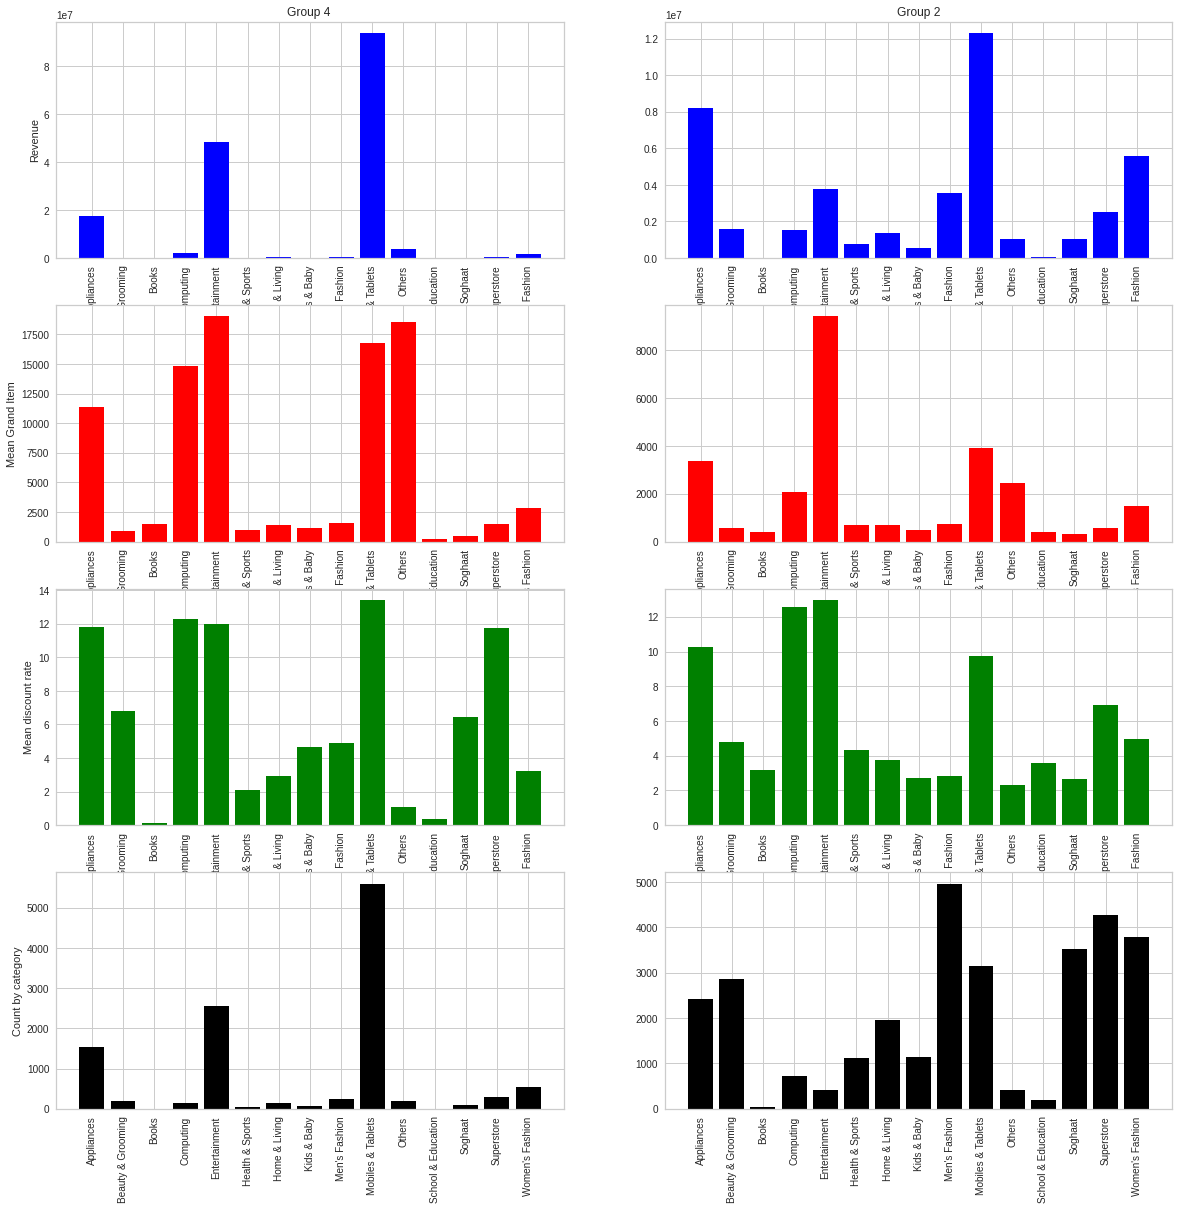

In [ ]:
result3d_sum_by_cat_4 = RFM_res_merged3d_Cluster4.groupby(['category_name_1'])['grand_item'].sum()
result3d_mean_by_cat_4 = RFM_res_merged3d_Cluster4.groupby(['category_name_1'])['grand_item'].mean()
result3d_dr_mean_by_cat_4 = RFM_res_merged3d_Cluster4.groupby(['category_name_1'])['discount_rate'].mean()
result3d_count_by_cat_4 = RFM_res_merged3d_Cluster4.groupby(['category_name_1']).count()


result3d_sum_by_cat_2 = RFM_res_merged3d_Cluster2.groupby(['category_name_1'])['grand_item'].sum()
result3d_mean_by_cat_2 = RFM_res_merged3d_Cluster2.groupby(['category_name_1'])['grand_item'].mean()
result3d_dr_mean_by_cat_2 = RFM_res_merged3d_Cluster2.groupby(['category_name_1'])['discount_rate'].mean()
result3d_count_by_cat_2 = RFM_res_merged3d_Cluster2.groupby(['category_name_1']).count()

g4 = pd.DataFrame(result3d_sum_by_cat_4)   
g4_mean = pd.DataFrame(result3d_mean_by_cat_4)   
g4_dr_mean = pd.DataFrame(result3d_dr_mean_by_cat_4)
g4_count = pd.DataFrame(result3d_count_by_cat_4)

g2 = pd.DataFrame(result3d_sum_by_cat_2)   
g2_mean = pd.DataFrame(result3d_mean_by_cat_2)   
g2_dr_mean = pd.DataFrame(result3d_dr_mean_by_cat_2)
g2_count = pd.DataFrame(result3d_count_by_cat_2)

plt.figure(figsize=(20,20))

plt.subplot(421)
plt.bar(g4.index, g4.grand_item, color='blue')
plt.xticks(rotation=90)
plt.ylabel('Revenue')
plt.title('Group 4 ')

plt.subplot(423)
plt.bar(g4_mean.index, g4_mean.grand_item, color='red' )
plt.xticks(rotation=90)
plt.ylabel('Mean Grand Item')
# plt.title('Mean Grand Item per category - Group 4')

plt.subplot(425)
plt.bar(g4_dr_mean.index, g4_dr_mean.discount_rate, color='green' )
plt.xticks(rotation=90)
plt.ylabel('Mean discount rate')
# plt.title('Mean discount rate per category - Group 4')

plt.subplot(427)
plt.bar(g4_count.index, g4_count.discount_rate, color='black' )
plt.xticks(rotation=90)
plt.ylabel('Count by category')
# plt.title('Count by Category - Group 4')


plt.subplot(422)
plt.bar(g2.index, g2.grand_item, color='blue')
plt.xticks(rotation=90)
# plt.ylabel('Revenue')
plt.title('Group 2')

plt.subplot(424)
plt.bar(g2_mean.index, g2_mean.grand_item, color='red' )
plt.xticks(rotation=90)
# plt.ylabel('Mean Grand Item')
# plt.title('Mean Grand Item per category - Group 2')

plt.subplot(426)
plt.bar(g2_dr_mean.index, g2_dr_mean.discount_rate, color='green' )
plt.xticks(rotation=90)
# plt.ylabel('Mean discount rate')
# plt.title('Mean discount rate per category - Group 2')

plt.subplot(428)
plt.bar(g2_count.index, g2_count.discount_rate, color='black' )
plt.xticks(rotation=90)
# plt.ylabel('count by category')
# plt.title('Count by Category - Group 2')


plt.show()


# Observations

#  Group 4- high monetary value / high frequency / low recency
# -> Revnue: mainly high quality mobiles & tables and top entertainment products, 
# -> discount rates: very high discount rates on 5 out of 13 categories (around 12 %)
# -> most customers in this group buy mobiles & tables and top entertainment products 

#  Group 2 - moetary some high values, but most of them have low values, high frequency, low rencency
# -> Revenue is driven mainly by Mobile & Tables (average quality producs), Appliances and Fashion(women's)
# -> mean price: compared with group4, the products are clearly cheaper
# -> discount rates are not that high, only in 2 out of 13 there is an discount average rate of around 12 %
# -> Customers: here we have mainly the most customers in categories Fashion (men & women),  Superstore(?) and Soghaat(Pakistan Sweets).

## Part 4 Choose best standardise scale approach

In [ ]:
RFM_rel_pred3.loc[('111', '112', '113', '114', '115'), :]

,M3_0,M3_1,M3_2,M3_3
RFM_rel_group,,,,
111,5105,0,0,0
112,2873,0,0,0
113,1677,0,0,0
114,1111,0,0,0
115,640,0,273,1


In [ ]:
RFM_rel_pred4.loc[('111', '112', '113', '114', '115'), :]

,M4_0,M4_1,M4_2,M4_3
RFM_rel_group,,,,
111,5105,0,0,0
112,2873,0,0,0
113,1677,0,0,0
114,1111,0,0,0
115,914,0,0,0




---



In [ ]:
RFM_rel_pred3.loc[('211', '212', '213', '214', '215'), :]

,M3_0,M3_1,M3_2,M3_3
RFM_rel_group,,,,
211,945,0,0,0
212,862,0,0,0
213,596,0,0,0
214,395,0,0,0
215,192,0,77,1


In [ ]:
RFM_rel_pred4.loc[('211', '212', '213', '214', '215'), :]

,M4_0,M4_1,M4_2,M4_3
RFM_rel_group,,,,
211,945,0,0,0
212,862,0,0,0
213,596,0,0,0
214,395,0,0,0
215,270,0,0,0




---



In [ ]:
RFM_rel_pred3.loc[('511', '512', '513', '514', '515'), :]

,M3_0,M3_1,M3_2,M3_3
RFM_rel_group,,,,
511,19,0,0,0
512,22,0,0,0
513,18,0,0,0
514,17,0,0,0
515,8,0,4,0


In [ ]:
RFM_rel_pred4.loc[('511', '512', '513', '514', '515'), :]

,M4_0,M4_1,M4_2,M4_3
RFM_rel_group,,,,
511,0,0,0,19
512,0,0,0,22
513,0,0,0,18
514,0,0,0,17
515,0,0,0,12


In [ ]:
RFM_rel_pred4.to_csv('RFM_rel_pred4.csv')
!cp RFM_rel_pred4.csv "drive/My Drive/"

In [ ]:
# Model 6

scaler = preprocessing.MinMaxScaler()

# Fit best number of clusters (see step 2)
kmeans = KMeans(n_clusters = 4, random_state = seed)
pipeline = make_pipeline(scaler, kmeans)
pipeline.fit(RFM_rel)
predicts = pipeline.predict(RFM_rel)
RFM_rel_group = RFM_rel_score['RFM_Rel_Score']
outcome = pd.DataFrame({'predicts': predicts, 'RFM_rel_group': RFM_rel_group})
RFM_rel_pred6 = pd.crosstab(outcome['RFM_rel_group'], outcome['predicts'])
RFM_rel_pred6.columns = ['M6_0', 'M6_1', 'M6_2', 'M6_3']

RFM_rel_pred = pd.merge(RFM_rel_pred, RFM_rel_pred6, on='RFM_rel_group')

# add now the predicted cluster to the RFM table
RFM_rel_res = RFM_rel_res.copy()
RFM_rel_res['Cluster6'] = kmeans.labels_

silhouette_score6 = silhouette_score(RFM_rel,kmeans.labels_,metric="sqeuclidean")
Inertia6 = kmeans.inertia_

print(silhouette_score6)
print(Inertia6)

-0.13438898011628375
871.903753182529


In [ ]:
RFM_rel_pred6.to_csv('RFM_rel_pred6.csv')
!cp RFM_rel_pred6.csv "drive/My Drive/"

In [ ]:
# Model 7
from sklearn.preprocessing import Normalizer
scaler = preprocessing.Normalizer()

# Fit best number of clusters (see step 2)
kmeans = KMeans(n_clusters = 4, random_state = seed)
pipeline = make_pipeline(scaler, kmeans)
pipeline.fit(RFM_rel)
predicts = pipeline.predict(RFM_rel)
RFM_rel_group = RFM_rel_score['RFM_Rel_Score']
outcome = pd.DataFrame({'predicts': predicts, 'RFM_rel_group': RFM_rel_group})
RFM_rel_pred7 = pd.crosstab(outcome['RFM_rel_group'], outcome['predicts'])
RFM_rel_pred7.columns = ['M7_0', 'M7_1', 'M7_2', 'M7_3']

RFM_rel_pred = pd.merge(RFM_rel_pred, RFM_rel_pred7, on='RFM_rel_group')

# add now the predicted cluster to the RFM table
RFM_rel_res = RFM_rel_res.copy()
RFM_rel_res['Cluster7'] = kmeans.labels_

silhouette_score7 = silhouette_score(RFM_rel,kmeans.labels_,metric="sqeuclidean")
Inertia7 = kmeans.inertia_

print(silhouette_score7)
print(Inertia7)

-0.38836818449570815
486.15645591776763


In [ ]:
RFM_rel_pred7.to_csv('RFM_rel_pred7.csv')
!cp RFM_rel_pred7.csv "drive/My Drive/"

In [ ]:
# Model 8: based on model 1, changed the standarlisation approach to normalizer
# Scale the data between 0 and 1
RFM=RFM_abs.copy().drop(["Customer ID"],axis=1)
scaler=preprocessing.Normalizer().fit(RFM)
RFM=scaler.transform(RFM)
#best k choosen by ellbow-method and silhouette analysis (see step 2)
kmeans=KMeans(n_clusters=4, random_state = seed)
kmeans.fit(RFM)
# add now the predicted cluster to the RFM table
RFM_res = RFM_abs.copy()
RFM_res['Cluster8'] = kmeans.labels_

silhouette_score8 = silhouette_score(RFM,kmeans.labels_,metric="sqeuclidean")
Inertia8 = kmeans.inertia_

print(silhouette_score8)
print(Inertia8)

0.7981835980458761
487.54157135942955


Objective:Normalizer is the best standardization approach according the inertia and silhouette scores. However, model 7 has more wider spread over clusters. Model 4 only happened for RFM group 3.

## Part 5 sub-models
RFM relative group 1,2,4,5 and 5 model separately.

In [ ]:
print(RFM_rel_score.shape)
print(RFM_rel_score.columns)
print(RFM_rel_score.dtypes)

(75264, 4)
Index(['Recency', 'Frequency_rel', 'Monetary', 'RFM_Rel_Score'], dtype='object')
Recency          category
Frequency_rel    category
Monetary         category
RFM_Rel_Score      object
dtype: object


In [ ]:
RFM_rel_R1245 = RFM_rel[RFM_rel_score['Recency'] != 3]
print(RFM_rel_R1245.shape)

(60163, 3)


In [ ]:
RFM_rel_R3 = RFM_rel[RFM_rel_score['Recency'] == 3]
print(RFM_rel_R3.shape)

(15101, 3)


In [ ]:
# Model 10 sub-model A: RFM_rel_R3

# Fit best number of clusters (see step 2)
kmeans = KMeans(n_clusters = 4, random_state = seed)
pipeline = make_pipeline(scaler, kmeans)
pipeline.fit(RFM_rel_R3)
predicts = pipeline.predict(RFM_rel_R3)

RFM_rel_group = RFM_rel_score['RFM_Rel_Score'][RFM_rel_score['Recency'] == 3]
outcome = pd.DataFrame({'predicts': predicts, 'RFM_rel_group': RFM_rel_group})

RFM_rel_pred10_1 = pd.crosstab(outcome['RFM_rel_group'], outcome['predicts'])
RFM_rel_pred10_1.columns = ['M10_1_0', 'M10_1_1', 'M10_1_2', 'M10_1_3']
# RFM_rel_pred = pd.merge(RFM_rel_pred, RFM_rel_pred10_1, on='RFM_rel_group')
# add now the predicted cluster to the RFM table
# RFM_rel_res10_1 = RFM_rel_R3.copy()
# RFM_rel_res10_1['Cluster10_1'] = kmeans.labels_

silhouette_score10_1 = silhouette_score(RFM_rel_R3,kmeans.labels_,metric="sqeuclidean")
Inertia10_1 = kmeans.inertia_

print(silhouette_score10_1)
print(Inertia10_1)

0.007925078538835577
12481.706700296822


In [ ]:
RFM_rel_pred10_1.to_csv('RFM_rel_pred10_1.csv')
!cp RFM_rel_pred10_1.csv "drive/My Drive/"

Object: The improvement in less wider spread to clusters - not quite.

## Part 6 T-SNE visualisation



In [ ]:
# Model 4:
from sklearn.manifold import TSNE

model = TSNE(learning_rate=200)

# tsne_features = model.fit_transform(RFM_rel)

pipeline = make_pipeline(scaler, model)
tsne_features = pipeline.fit_transform(RFM_rel)

In [ ]:
# c = RFM_rel_score['Frequency_rel']
# c = RFM_rel_score['Recency']
# c = RFM_rel_score['Monetary']
c = RFM_rel_score['RFM_Rel_Score']

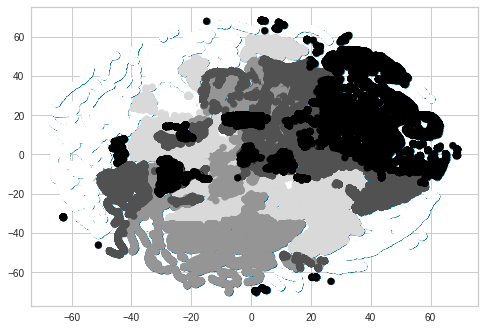

In [ ]:
xs = tsne_features[:,0]
ys = tsne_features[:,1]

# Scatter plot
plt.scatter(xs,ys,alpha=0.5)

plt.scatter(xs,ys, c=RFM_rel_score['Recency'])
plt.show()


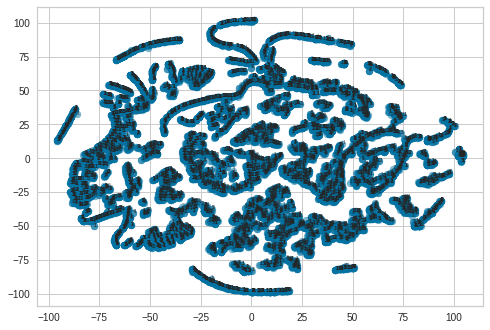

In [ ]:
xs = tsne_features[:,0]
ys = tsne_features[:,1]

# Scatter plot
plt.scatter(xs,ys,alpha=0.5)
for x, y, c in zip(xs, ys, RFM_rel_score['Recency']):
    plt.annotate(c, (x, y), fontsize=5, alpha=0.75)

plt.show()

In [ ]:
# Model 4:
from sklearn.manifold import TSNE

model = TSNE(learning_rate=500)

# tsne_features = model.fit_transform(RFM_rel)

pipeline = make_pipeline(scaler, model)
tsne_features = pipeline.fit_transform(RFM_rel)

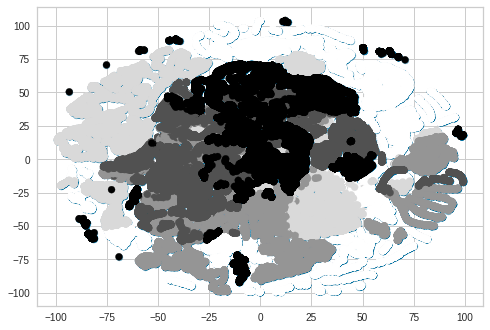

In [ ]:
xs = tsne_features[:,0]
ys = tsne_features[:,1]

# Scatter plot
plt.scatter(xs,ys,alpha=0.5)

plt.scatter(xs,ys, c=RFM_rel_score['Recency'])
plt.show()

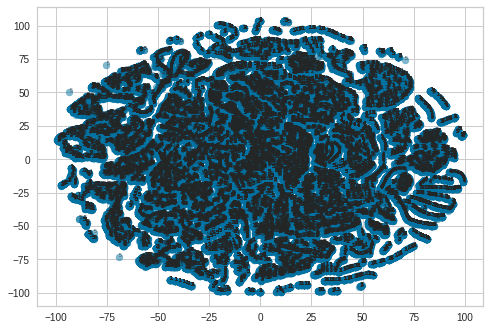

In [ ]:
xs = tsne_features[:,0]
ys = tsne_features[:,1]

# Scatter plot
plt.scatter(xs,ys,alpha=0.5)
for x, y, c in zip(xs, ys, RFM_rel_score['Recency']):
    plt.annotate(c, (x, y), fontsize=5, alpha=0.75)

plt.show()

Object: re-try different learning_rate

## Part 7 PCA variance

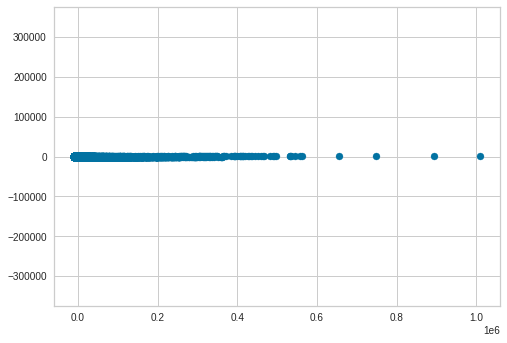

-8.326672684688674e-17
0.9999999998657091


In [ ]:
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
model = PCA()

# pca_features = model.fit_transform(RFM_rel)

pipeline = make_pipeline(scaler, model)
pca_features = pipeline.fit_transform(RFM_rel)


xs = pca_features[:,0]
ys = pca_features[:,1]

plt.scatter(xs, ys)
plt.axis('equal')
plt.show()

correlation, pvalue = pearsonr(xs, ys)
print(correlation)
print(pvalue)

Object: no correlations among these 3 factors.